### Conditions description:
<ul>
    <li>C1 = low interference, easy search -> 'SearchDomain' diff, 'SearchLevel' easy</li>
    <li>C2 = low interference, hard search -> 'SearchDomain' diff, 'SearchLevel' hard</li>
    <li>C3 = high interference, easy search -> 'SearchDomain' same, 'SearchLevel' easy</li>
    <li>C4 = high interference, hard search -> 'SearchDomain' same, 'SearchLevel' hard</li>
</ul>

Questions/Notes: 
<br> Second vs glm gets faster significant voxels (.2 > .6)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
import nilearn
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from nilearn.plotting import plot_design_matrix
from nilearn.image import concat_imgs, mean_img, resample_img
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn import plotting
from bids import BIDSLayout, BIDSValidator

/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load fMRI data (and get some scannings info)

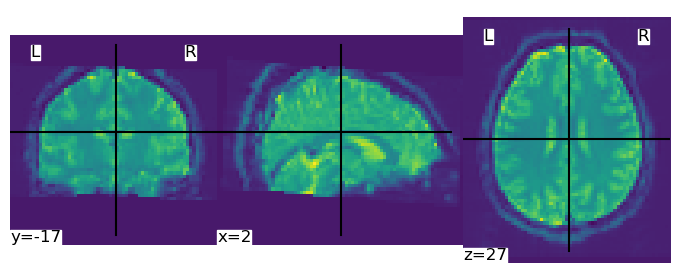

In [2]:
# First run data
img = nib.load("DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz")
path = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
fmri_img = concat_imgs(path)

# Obtain mean image from first participant fmri session
# 'mean_img' will be useful to set a background to plot contrasts against it
mean_img = mean_img(fmri_img)
plotting.plot_img(mean_img)
plt.show()

# Read scanning info from file 
# Important, get 'tr' information
#header = img.header
#print(header.get_zooms()) # tr=2
tr = 2
#print(header)

## Load the 8 runs fmri data

In [3]:
path1 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path2 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path3 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-03_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path4 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-04_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path5 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-05_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path6 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-06_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path7 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-07_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
path8 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-08_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"

fmri_img = [concat_imgs(path1, auto_resample=True),
            concat_imgs(path2, auto_resample=True),
            concat_imgs(path3, auto_resample=True),
            concat_imgs(path4, auto_resample=True),
            concat_imgs(path5, auto_resample=True),
            concat_imgs(path6, auto_resample=True),
            concat_imgs(path7, auto_resample=True),
            concat_imgs(path8, auto_resample=True)]
           
affine, shape = fmri_img[0].affine, fmri_img[0].shape

# Resampling images to fit same affine
# Though, I think they already have the same affine
fmri_img[1] = resample_img(fmri_img[1], affine, shape[:3])
fmri_img[2] = resample_img(fmri_img[2], affine, shape[:3])
fmri_img[3] = resample_img(fmri_img[3], affine, shape[:3])
fmri_img[4] = resample_img(fmri_img[4], affine, shape[:3])
fmri_img[5] = resample_img(fmri_img[5], affine, shape[:3])
fmri_img[6] = resample_img(fmri_img[6], affine, shape[:3])
fmri_img[7] = resample_img(fmri_img[7], affine, shape[:3])
print('Resampling done.')
print("Total fmri data files: " + str(len(fmri_img)))

Resampling done.
Total fmri data files: 8


In [4]:
fmri_img4C1 = [fmri_img[0], fmri_img[1], fmri_img[3], fmri_img[4], fmri_img[5], fmri_img[6], fmri_img[7]]

In [5]:
#mean_img = mean_img([fmri_img[0], fmri_img[1], fmri_img[2], fmri_img[3], fmri_img[4], fmri_img[5], fmri_img[6], fmri_img[7]])


## Load events (task/behavioral data)

In [6]:
# Formating behavioral data to a panda format
# Path to behavioral data file
e_path1 = "DistractWM2/behavioral_data/DistractWM_scanner_shorter_newStim102.txt"

# Reformat data to csv file
data2 = pd.read_csv(e_path1, sep=" ")
path2 = "data2.csv"
data2.to_csv(path2, sep='\t')

In [7]:
# Load events data in panda dataframe(df)
df = pd.read_csv("data2.csv", sep='\t') 
df1 = df[df["block"] == 1].reset_index()
df2 = df[df["block"] == 2].reset_index()
df3 = df[df["block"] == 3].reset_index()
df4 = df[df["block"] == 4].reset_index()
df5 = df[df["block"] == 5].reset_index()
df6 = df[df["block"] == 6].reset_index()
df7 = df[df["block"] == 7].reset_index()
df8 = df[df["block"] == 8].reset_index()
total_dfs = [df1, df2, df3, df4, df5, df6, df7, df8]


In [8]:
# Function to extract relevant event information 
# to be used in 'cue glm'

def extracting_events_info_4cue(data_df):
    
    events_cue = pd.DataFrame()
    
    #num_of_trials = df["block"].size
    # Process data for 'events df'
    for x in range(24):

        # Formating data for 'cue', 'probe' and 'visual search' events
        cue_onset = data_df["cueShow"][x] 
        probe_onset = data_df["probeStart"][x] 
        vs_onset = data_df["searchStart"][x]  

        probe_duration = data_df["ProbeDuration"][x]
        vs_duration = data_df["SearchDuration"][x]
        cue_duration = data_df["CueDuration"][x]

        # Useful vars to sort vs category
        probe = data_df["targstim"][x]
        probe_interference = data_df["SearchDomain"][x]
        probe_att_d = data_df["SearchLevel"][x]
    
        # Categorize each run according to 'type of stimuli', 'level of interference' and 'attentional demand'
        if((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "house_cue"
            probe_type = "probe" 
            visual_search_type = "C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "house_cue"
            probe_type = "probe"
            visual_search_type = "C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "house_cue"
            probe_type = "probe" 
            visual_search_type = "C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "house_cue"
            probe_type = "probe" 
            visual_search_type = "C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_cue = events_cue.append(vs_event, ignore_index = True)

        cue_event = pd.DataFrame(data={'trial_type': cue_type, 'onset': cue_onset, 'duration': cue_duration}, index=range(1))
        probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1))
    
        # Appending data to events df
        events_cue = events_cue.append(cue_event, ignore_index = True)
        events_cue = events_cue.append(probe_event, ignore_index = True)
        
    return events_cue

In [9]:
# Function to extract relevant event information 
# to be used in 'vs glm'

def extracting_events_info_4vs(data_df):
    
    events_vs = pd.DataFrame()
    
    #num_of_trials = df["block"].size
    # Process data for 'events df'
    for x in range(24):

        # Formating data for 'cue', 'probe' and 'visual search' events
        cue_onset = data_df["cueShow"][x] 
        probe_onset = data_df["probeStart"][x] 
        vs_onset = data_df["searchStart"][x]

        probe_duration = data_df["ProbeDuration"][x]
        vs_duration = data_df["SearchDuration"][x]
        cue_duration = data_df["CueDuration"][x]

        # Useful vars to sort vs category
        probe = data_df["targstim"][x]
        probe_interference = data_df["SearchDomain"][x]
        probe_att_d = data_df["SearchLevel"][x]
    
        # Categorize each run according to 'type of stimuli', 'level of interference' and 'attentional demand'
        if((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe"
            visual_search_type = "C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)

        cue_event = pd.DataFrame(data={'trial_type': cue_type, 'onset': cue_onset, 'duration': cue_duration}, index=range(1))
        probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1))
    
        # Appending data to events df
        events_vs = events_vs.append(cue_event, ignore_index = True)
        events_vs = events_vs.append(probe_event, ignore_index = True)
        
    return events_vs

In [10]:
# Function to extract relevant event information 
# to be used in 'vs2 glm'

def extracting_events_info_4vs2(data_df):
    
    events_vs = pd.DataFrame()
    
    #num_of_trials = df["block"].size
    # Process data for 'events df'
    for x in range(24):

        # Formating data for 'cue', 'probe' and 'visual search' events
        cue_onset = data_df["cueShow"][x] 
        probe_onset = data_df["probeStart"][x] 
        vs_onset = data_df["searchStart"][x]

        probe_duration = data_df["ProbeDuration"][x]
        vs_duration = data_df["SearchDuration"][x]
        cue_duration = data_df["CueDuration"][x]

        # Useful vars to sort vs category
        probe = data_df["targstim"][x]
        probe_interference = data_df["SearchDomain"][x]
        probe_att_d = data_df["SearchLevel"][x]
    
        # Categorize each run according to 'type of stimuli', 'level of interference' and 'attentional demand'
        if((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "House_C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "Face_C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe"
            visual_search_type = "House_C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "Face_C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "House_C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "Face_C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "House_C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "cue"
            probe_type = "probe" 
            visual_search_type = "Face_C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)

        cue_event = pd.DataFrame(data={'trial_type': cue_type, 'onset': cue_onset, 'duration': cue_duration}, index=range(1))
        probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1))
    
        # Appending data to events df
        events_vs = events_vs.append(cue_event, ignore_index = True)
        events_vs = events_vs.append(probe_event, ignore_index = True)
        
    return events_vs

In [11]:
def extracting_events_info_4probe(data_df):
    
    events_probe = pd.DataFrame()
    
    #num_of_trials = df["block"].size
    # Process data for 'events df'
    for x in range(24):

        # Formating data for 'cue', 'probe' and 'visual search' events
        cue_onset = data_df["cueShow"][x] 
        probe_onset = data_df["probeStart"][x] 
        vs_onset = data_df["searchStart"][x]  

        probe_duration = data_df["ProbeDuration"][x]
        vs_duration = data_df["SearchDuration"][x]
        cue_duration = data_df["CueDuration"][x]

        # Useful vars to sort vs category
        probe = data_df["targstim"][x]
        probe_interference = data_df["SearchDomain"][x]
        probe_att_d = data_df["SearchLevel"][x]
        probe_acc = data_df["probeACC"][x]
    
        cue_type = "cue"
        cue_event = pd.DataFrame(data={'trial_type': cue_type, 'onset': cue_onset, 'duration': cue_duration}, index=range(1))
        
        # Categorize each visual search
        if((probe_interference == "diff") and (probe_att_d == "easy")):
            visual_search_type = "C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)
        elif((probe_interference == "diff") and (probe_att_d == "easy")):
            visual_search_type = "C1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)
        elif((probe_interference == "diff") and (probe_att_d == "hard")):
            visual_search_type = "C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)
        elif((probe_interference == "diff") and (probe_att_d == "hard")):
            visual_search_type = "C2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)
        elif((probe_interference == "same") and (probe_att_d == "easy")):
            visual_search_type = "C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)
        elif((probe_interference == "same") and (probe_att_d == "easy")):
            visual_search_type = "C3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)
        elif((probe_interference == "same") and (probe_att_d == "hard")):
            visual_search_type = "C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)
        elif((probe_interference == "same") and (probe_att_d == "hard")): 
            visual_search_type = "C4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_probe = events_probe.append(vs_event, ignore_index = True)

        # Categorize each probe according to category (house-face) and 'accuracy' (0-1)
        if((probe[:5] == "House") and (probe_acc == 1)):
            probe_type = "House_correct"
            probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1))
            events_probe = events_probe.append(probe_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_acc == 1)):
            probe_type = "Face_correct"
            probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1)) 
            events_probe = events_probe.append(probe_event, ignore_index = True) 
        elif((probe[:5] == "House") and (probe_acc == 0)):
            probe_type = "House_incorrect"
            probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1))
            events_probe = events_probe.append(probe_event, ignore_index = True)                           
        elif((probe[:5] != "House") and (probe_acc == 0)):
            probe_type = "Face_incorrect"
            probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1)) 
            events_probe = events_probe.append(probe_event, ignore_index = True)                    
        # Appending data to events df
        events_probe = events_probe.append(cue_event, ignore_index = True)
        
    return events_probe

In [12]:
# Get events info formated for 'cue_glm'
events_cue1 = extracting_events_info_4cue(df1)
events_cue2 = extracting_events_info_4cue(df2)
events_cue3 = extracting_events_info_4cue(df3)
events_cue4 = extracting_events_info_4cue(df4)
events_cue5 = extracting_events_info_4cue(df5)
events_cue6 = extracting_events_info_4cue(df6)
events_cue7 = extracting_events_info_4cue(df7)
events_cue8 = extracting_events_info_4cue(df8)

# Append all event info to a list
events_cue = [events_cue1, events_cue2, events_cue3, events_cue4, events_cue5, events_cue6, events_cue7, events_cue8]
print("Total events_cue files: " + str(len(events_cue)))

# Sample of event information
events_cue1.sort_values(by="onset", axis=0, inplace=True)
events_cue1.head(10)

Total events_cue files: 8


,trial_type,onset,duration
1,house_cue,7.118972,1
0,C3,9.202374,3
2,probe,13.252500,2
4,house_cue,17.302450,1
3,C3,23.385790,3
5,probe,31.435660,2
7,house_cue,35.985590,1
6,C3,38.552250,3
8,probe,42.602320,2
10,face_cue,48.652360,1


In [13]:
# Get events info formated for 'vs_glm'
events_vs1 = extracting_events_info_4vs(df1)
events_vs2 = extracting_events_info_4vs(df2)
events_vs3 = extracting_events_info_4vs(df3)
events_vs4 = extracting_events_info_4vs(df4)
events_vs5 = extracting_events_info_4vs(df5)
events_vs6 = extracting_events_info_4vs(df6)
events_vs7 = extracting_events_info_4vs(df7)
events_vs8 = extracting_events_info_4vs(df8)

# Append all event info to a list
events_vs = [events_vs1, events_vs2, events_vs3, events_vs4, events_vs5, events_vs6, events_vs7, events_vs8]
print("Total events_vs files: " + str(len(events_vs)))

# Sample of event information
events_vs1.sort_values(by="onset", axis=0, inplace=True)
events_vs1.head(10)

Total events_vs files: 8


,trial_type,onset,duration
1,cue,7.118972,1
0,C3,9.202374,3
2,probe,13.252500,2
4,cue,17.302450,1
3,C3,23.385790,3
5,probe,31.435660,2
7,cue,35.985590,1
6,C3,38.552250,3
8,probe,42.602320,2
10,cue,48.652360,1


In [14]:
# Get events info formated for 'vs2_glm'
events_vs2_1 = extracting_events_info_4vs2(df1)
events_vs2_2 = extracting_events_info_4vs2(df2)
events_vs2_3 = extracting_events_info_4vs2(df3)
events_vs2_4 = extracting_events_info_4vs2(df4)
events_vs2_5 = extracting_events_info_4vs2(df5)
events_vs2_6 = extracting_events_info_4vs2(df6)
events_vs2_7 = extracting_events_info_4vs2(df7)
events_vs2_8 = extracting_events_info_4vs2(df8)

# Append all event info to a list
events_vs2 = [events_vs2_1, events_vs2_2, events_vs2_4, events_vs2_5, events_vs2_6, events_vs2_7, events_vs2_8]
print("Total events_vs2 files: " + str(len(events_vs2)))

# Sample of event information
events_vs2_1.sort_values(by="onset", axis=0, inplace=True)
events_vs2_1.head(10)

Total events_vs2 files: 7


,trial_type,onset,duration
1,cue,7.118972,1
0,House_C3,9.202374,3
2,probe,13.252500,2
4,cue,17.302450,1
3,House_C3,23.385790,3
5,probe,31.435660,2
7,cue,35.985590,1
6,House_C3,38.552250,3
8,probe,42.602320,2
10,cue,48.652360,1


In [15]:
# Get events info formated for 'probe_glm'
events_probe1 = extracting_events_info_4probe(df1)
events_probe2 = extracting_events_info_4probe(df2)
events_probe3 = extracting_events_info_4probe(df3)
events_probe4 = extracting_events_info_4probe(df4)
events_probe5 = extracting_events_info_4probe(df5)
events_probe6 = extracting_events_info_4probe(df6)
events_probe7 = extracting_events_info_4probe(df7)
events_probe8 = extracting_events_info_4probe(df8)

# Append all event info to a list
events_probe = [events_probe1, events_probe2, events_probe3, events_probe4, events_probe5, events_probe6, events_probe7, events_probe8]
print("Total events_probe files: " + str(len(events_probe)))

# Sample of event information
events_probe1.sort_values(by="onset", axis=0, inplace=True)
events_probe1.head(10)


Total events_probe files: 8


,trial_type,onset,duration
2,cue,7.118972,1
0,C3,9.202374,3
1,House_incorrect,13.252500,2
5,cue,17.302450,1
3,C3,23.385790,3
4,House_incorrect,31.435660,2
8,cue,35.985590,1
6,C3,38.552250,3
7,House_correct,42.602320,2
11,cue,48.652360,1


In [16]:
# Exploring c1 events
#events_vs1[events_vs1['trial_type'] == 'face_c1'] #2
#events_vs1[events_vs1['trial_type'] == 'house_c1'] #4
#events_vs2[events_vs2['trial_type'] == 'face_c1'] #3
#events_vs2[events_vs2['trial_type'] == 'house_c1'] #3 
#events_vs3[events_vs3['trial_type'] == 'face_c1'] # -> 0 
#events_vs3[events_vs3['trial_type'] == 'house_c1'] #6
#events_vs4[events_vs4['trial_type'] == 'face_c1'] # 2 
#events_vs4[events_vs4['trial_type'] == 'house_c1'] #4
#events_vs5[events_vs5['trial_type'] == 'face_c1'] # 4 
#events_vs5[events_vs5['trial_type'] == 'house_c1'] #2
#events_vs6[events_vs6['trial_type'] == 'face_c1'] # 4 
#events_vs6[events_vs6['trial_type'] == 'house_c1'] #2
#events_vs7[events_vs7['trial_type'] == 'face_c1'] # 3 
#events_vs7[events_vs7['trial_type'] == 'house_c1'] #3
#events_vs8[events_vs8['trial_type'] == 'face_c1'] # 2 
#events_vs8[events_vs8['trial_type'] == 'house_c1'] #4

"""
For C1, I'm going to omit run 3. As it has 0 'face_c1' conditions, which seems to generate a bug. 
"""

"\nFor C1, I'm going to omit run 3. As it has 0 'face_c1' conditions, which seems to generate a bug. \n"

In [17]:
# Exploring c2 events
#events_vs1[events_vs1['trial_type'] == 'face_c2'] #4
#events_vs1[events_vs1['trial_type'] == 'house_c2'] #2
#events_vs2[events_vs2['trial_type'] == 'face_c2'] #2
#events_vs2[events_vs2['trial_type'] == 'house_c2'] #4
#events_vs3[events_vs3['trial_type'] == 'face_c2'] #4
#events_vs3[events_vs3['trial_type'] == 'house_c2'] #2 
#events_vs4[events_vs4['trial_type'] == 'face_c2'] #2
#events_vs4[events_vs4['trial_type'] == 'house_c2'] #4
#events_vs5[events_vs5['trial_type'] == 'face_c2'] #2
#events_vs5[events_vs5['trial_type'] == 'house_c2'] #4
#events_vs6[events_vs6['trial_type'] == 'face_c2'] #3
#events_vs6[events_vs6['trial_type'] == 'house_c2'] #3 
#events_vs7[events_vs7['trial_type'] == 'face_c2'] #2
#events_vs7[events_vs7['trial_type'] == 'house_c2'] #4
#events_vs8[events_vs8['trial_type'] == 'face_c2'] #3
#events_vs8[events_vs8['trial_type'] == 'house_c2'] #3

In [18]:
### Exploring c3 events
#events_vs1[events_vs1['trial_type'] == 'face_c3'] #1
#events_vs1[events_vs1['trial_type'] == 'house_c3'] #5
#events_vs2[events_vs2['trial_type'] == 'face_c3'] #4
#events_vs2[events_vs2['trial_type'] == 'house_c3'] #2
#events_vs3[events_vs3['trial_type'] == 'face_c3'] #4
#events_vs3[events_vs3['trial_type'] == 'house_c3'] #2
#events_vs4[events_vs4['trial_type'] == 'face_c3'] #5
#events_vs4[events_vs4['trial_type'] == 'house_c3'] #1
#events_vs5[events_vs5['trial_type'] == 'face_c3'] #3
#events_vs5[events_vs5['trial_type'] == 'house_c3'] #3
#events_vs6[events_vs6['trial_type'] == 'face_c3'] #2
#events_vs6[events_vs6['trial_type'] == 'house_c3'] #4 
#events_vs7[events_vs7['trial_type'] == 'face_c3'] #3
#events_vs7[events_vs7['trial_type'] == 'house_c3'] #3
#events_vs8[events_vs8['trial_type'] == 'face_c3'] #4
#events_vs8[events_vs8['trial_type'] == 'house_c3'] #2

In [19]:
# Exploring c4 events
#events_vs1[events_vs1['trial_type'] == 'face_c4'] #5
#events_vs1[events_vs1['trial_type'] == 'house_c4'] #1
#events_vs2[events_vs2['trial_type'] == 'face_c4'] #3
#events_vs2[events_vs2['trial_type'] == 'house_c4'] #3
#events_vs3[events_vs3['trial_type'] == 'face_c4'] #4
#events_vs3[events_vs3['trial_type'] == 'house_c4'] #2
#events_vs4[events_vs4['trial_type'] == 'face_c4'] #3
#events_vs4[events_vs4['trial_type'] == 'house_c4'] #3
#events_vs5[events_vs5['trial_type'] == 'face_c4'] #3
#events_vs5[events_vs5['trial_type'] == 'house_c4'] #3
#events_vs6[events_vs6['trial_type'] == 'face_c4'] #3
#events_vs6[events_vs6['trial_type'] == 'house_c4'] #3
#events_vs7[events_vs7['trial_type'] == 'face_c4'] #4
#events_vs7[events_vs7['trial_type'] == 'house_c4'] #2
#events_vs8[events_vs8['trial_type'] == 'face_c4'] #3
#events_vs8[events_vs8['trial_type'] == 'house_c4'] #3

## Load confounds data

In [20]:
# Getting confounds data
confounds_path1 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-01_bold_confounds.tsv"
confounds_path2 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-02_bold_confounds.tsv"
confounds_path3 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-03_bold_confounds.tsv"
confounds_path4 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-04_bold_confounds.tsv"
confounds_path5 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-05_bold_confounds.tsv"
confounds_path6 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-06_bold_confounds.tsv"
confounds_path7 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-07_bold_confounds.tsv"
confounds_path8 = "DistractWM2/preprocessed_data/sub-102/func/sub-102_task-DistractWM_run-08_bold_confounds.tsv"

confounds1 = pd.read_csv(confounds_path1, delimiter='\t')
confounds1 = confounds1.fillna(0)
confounds2 = pd.read_csv(confounds_path2, delimiter='\t')
confounds2 = confounds2.fillna(0)
confounds3 = pd.read_csv(confounds_path3, delimiter='\t')
confounds3 = confounds3.fillna(0)
confounds4 = pd.read_csv(confounds_path4, delimiter='\t')
confounds4 = confounds4.fillna(0)
confounds5 = pd.read_csv(confounds_path5, delimiter='\t')
confounds5 = confounds5.fillna(0)
confounds6 = pd.read_csv(confounds_path6, delimiter='\t')
confounds6 = confounds6.fillna(0)
confounds7 = pd.read_csv(confounds_path7, delimiter='\t')
confounds7 = confounds7.fillna(0)
confounds8 = pd.read_csv(confounds_path8, delimiter='\t')
confounds8 = confounds8.fillna(0)
print(confounds1.keys())

confounds1 = confounds1[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds2 = confounds2[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds3 = confounds3[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds4 = confounds4[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds5 = confounds5[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds6 = confounds6[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds7 = confounds7[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 
confounds8 = confounds8[['WhiteMatter', 'GlobalSignal','FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']] 

confounds = [confounds1, confounds2, confounds3, confounds4, confounds5, confounds6, confounds7, confounds8]
confounds4C1 = [confounds1, confounds2, confounds4, confounds5, confounds6, confounds7, confounds8]


Index(['WhiteMatter', 'GlobalSignal', 'stdDVARS', 'non-stdDVARS',
       'vx-wisestdDVARS', 'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
       'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00',
       'aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05',
       'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03',
       'NonSteadyStateOutlier00', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'],
      dtype='object')


In [21]:
confounds1.head()

,WhiteMatter,GlobalSignal,FramewiseDisplacement,X,Y,Z,RotX,RotY,RotZ
0,-2.828596,7.065146,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
1,-1.291817,0.310452,0.042650,0.000000,0.005268,0.037382,0.000000,-0.000000,0.000000
2,-4.467258,-1.236966,0.126039,-0.031112,0.000020,0.098699,0.000000,-0.000195,0.000372
3,-4.472045,-3.235923,0.108469,-0.055635,0.008943,0.130467,0.000268,0.000154,0.000620
4,-2.273158,-2.253800,0.072397,-0.032421,0.014122,0.105469,0.000467,-0.000027,0.000620


## Make 1st level generalized linear models (cue, probe, visual search)

In [22]:
from nilearn.glm.first_level import FirstLevelModel

# Generate FirstLevelModel object 
fmri_glm_cue = FirstLevelModel(t_r=tr,
                            high_pass=0.007, # high_pass=0.007
                           standardize=False,
                           drift_model='cosine', 
                           hrf_model='spm',
                           smoothing_fwhm=5)

fmri_glm_probe = FirstLevelModel(t_r=tr,
                            high_pass=0.01, 
                           standardize=False,
                           drift_model='cosine', 
                           hrf_model='spm + derivative',
                           smoothing_fwhm=5)

"""
Notes probe (Face - House): 
High pass: 0.007, 0.007,
Fdr(0.05) threshold: 4.7, 3.9, 3.9
Hdr_model: spm, spm+d, spm+d
"""

fmri_glm_vs = FirstLevelModel(t_r=tr,
                            high_pass=0.025, #0.02, 0.015(4.4), 0.025(4.3), 0.035(4.6)
                           standardize=False,
                           drift_model='cosine', 
                           hrf_model='spm + derivative',
                           smoothing_fwhm=5)

fmri_glm_vs2 = FirstLevelModel(t_r=tr,
                            high_pass=0.015, 
                           standardize=False,
                           drift_model='cosine', 
                           hrf_model='spm + derivative',
                           smoothing_fwhm=5)

"""
Notes vs2(High/low interference): 

High pass: 0.01, 0.01, 0.015, 0.02,
Fdr(0.05) threshold: 3.9, 3.7, 3.6, 3.8,
Hdr_model: spm, spm+d, spm+d, spm+d,

"""


'\nNotes vs2(High/low interference): \n\nHigh pass: 0.01, 0.01, 0.015, 0.02,\nFdr(0.05) threshold: 3.9, 3.7, 3.6, 3.8,\nHdr_model: spm, spm+d, spm+d, spm+d,\n\n'

In [23]:
# Fit fmri, events, and confounds data to the FirstLevelModel object
fmri_glm_cue = fmri_glm_cue.fit(run_imgs=fmri_img, events=events_cue, confounds=confounds)
fmri_glm_probe = fmri_glm_probe.fit(run_imgs=fmri_img, events=events_probe, confounds=confounds)
fmri_glm_vs = fmri_glm_vs.fit(run_imgs=fmri_img, events=events_vs, confounds=confounds)
fmri_glm_vs2 = fmri_glm_vs2.fit(run_imgs=fmri_img4C1, events=events_vs2, confounds=confounds4C1)


In [24]:
dm_cue = fmri_glm_cue.design_matrices_
dm_probe = fmri_glm_probe.design_matrices_
dm_vs = fmri_glm_vs.design_matrices_
dm_vs2 = fmri_glm_vs2.design_matrices_

print("Number of design matrices computed fmri_glm_cue: " + str(len(dm_cue)))
print("Number of design matrices computed fmri_glm_probe: " + str(len(dm_probe)))
print("Number of design matrices computed fmri_glm_vs: " + str(len(dm_vs)))
print("Number of design matrices computed fmri_glm_vs2: " + str(len(dm_vs2)))

Number of design matrices computed fmri_glm_cue: 8
Number of design matrices computed fmri_glm_probe: 8
Number of design matrices computed fmri_glm_vs: 8
Number of design matrices computed fmri_glm_vs2: 7


## Plot Design matrices (only showing 1st matrices from 1st fmri run)

### Plot Design matrix 'fmri_glm_cue'

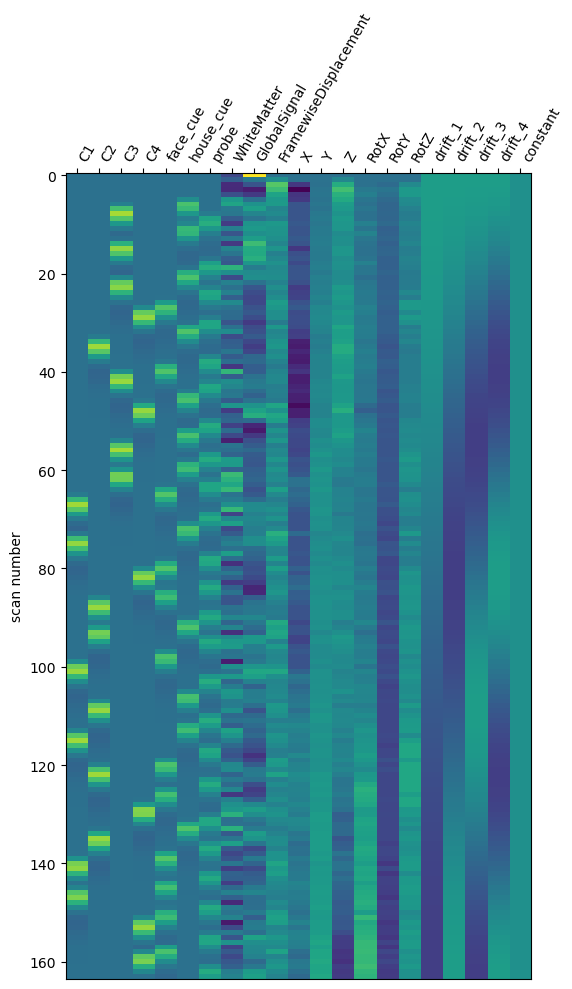

In [25]:
# Obtain and plot design matrix
design_matrix_cue = fmri_glm_cue.design_matrices_[0]
plot_design_matrix(design_matrix_cue)
plt.show()

### Plot Design matrix 'fmri_glm_probe'

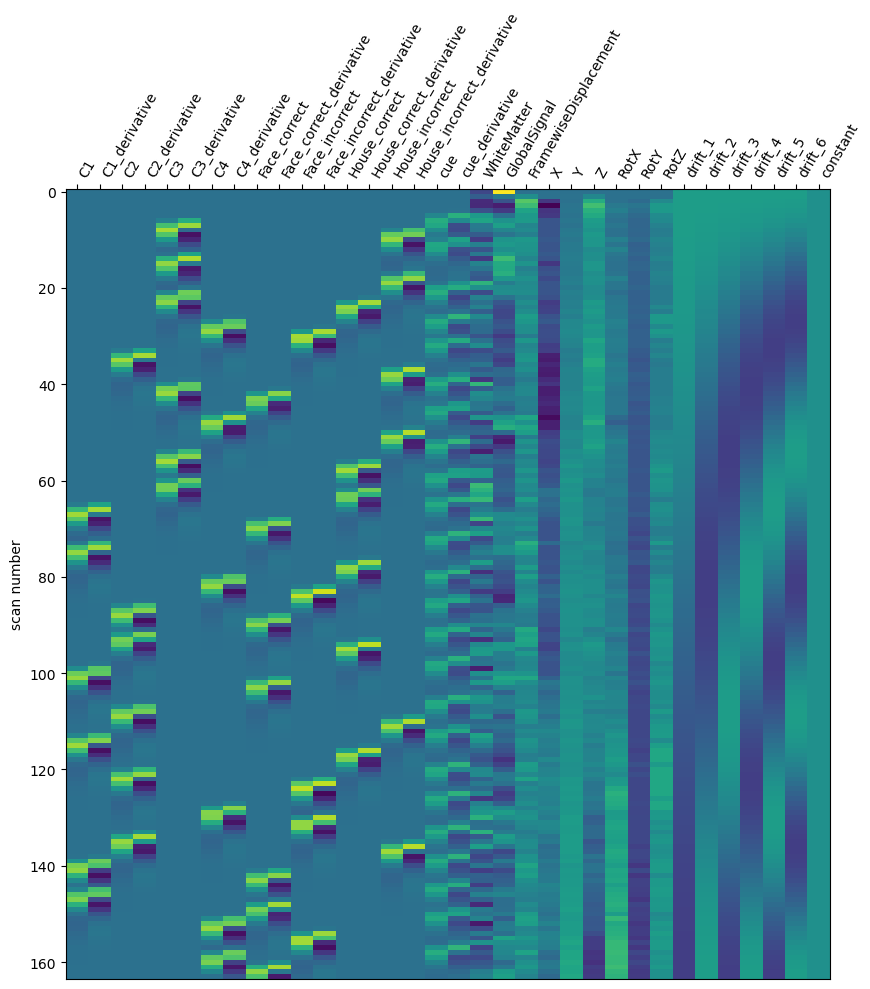

In [26]:
# Obtain and plot design matrix
design_matrix_probe = fmri_glm_probe.design_matrices_[0]
plot_design_matrix(design_matrix_probe)
plt.show()

### Plot Design matrix 'fmri_glm_vs'

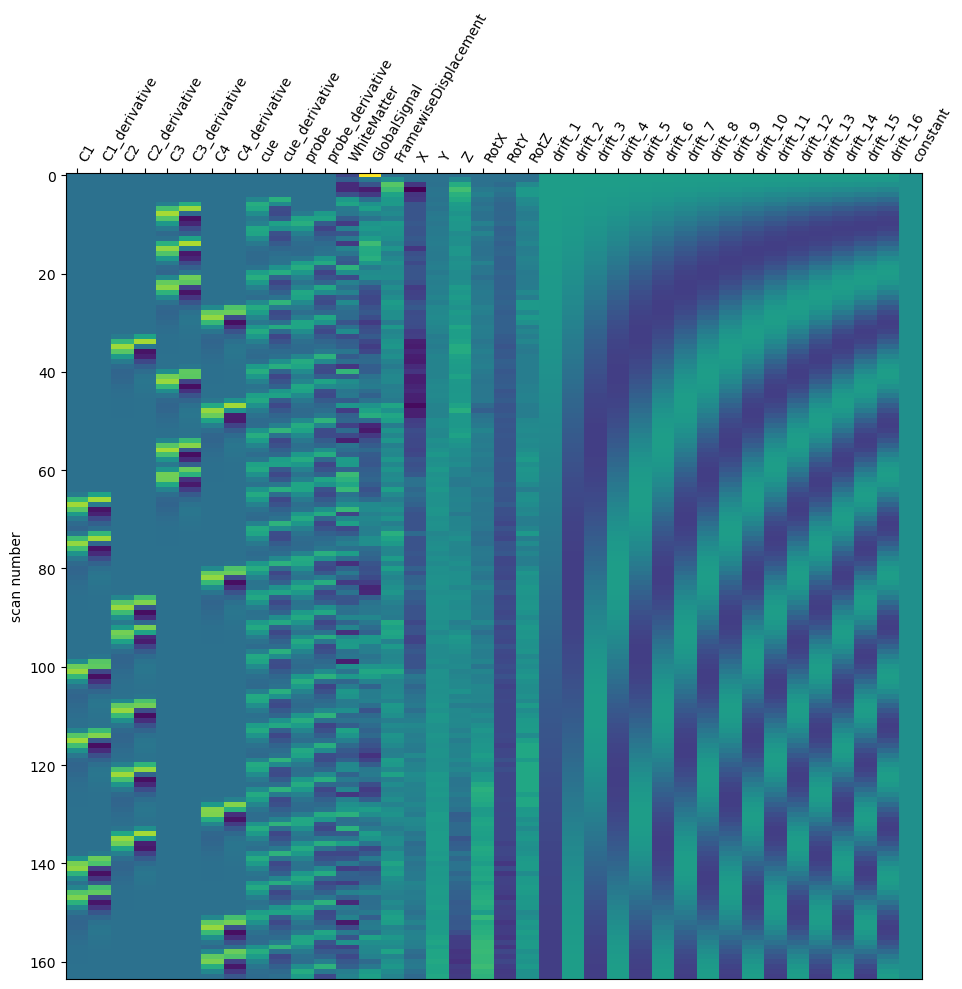

In [27]:
# Obtain and plot design matrix
design_matrix_vs = fmri_glm_vs.design_matrices_[0]
plot_design_matrix(design_matrix_vs)
plt.show()

### Plot Design matrix 'fmri_glm_vs2'

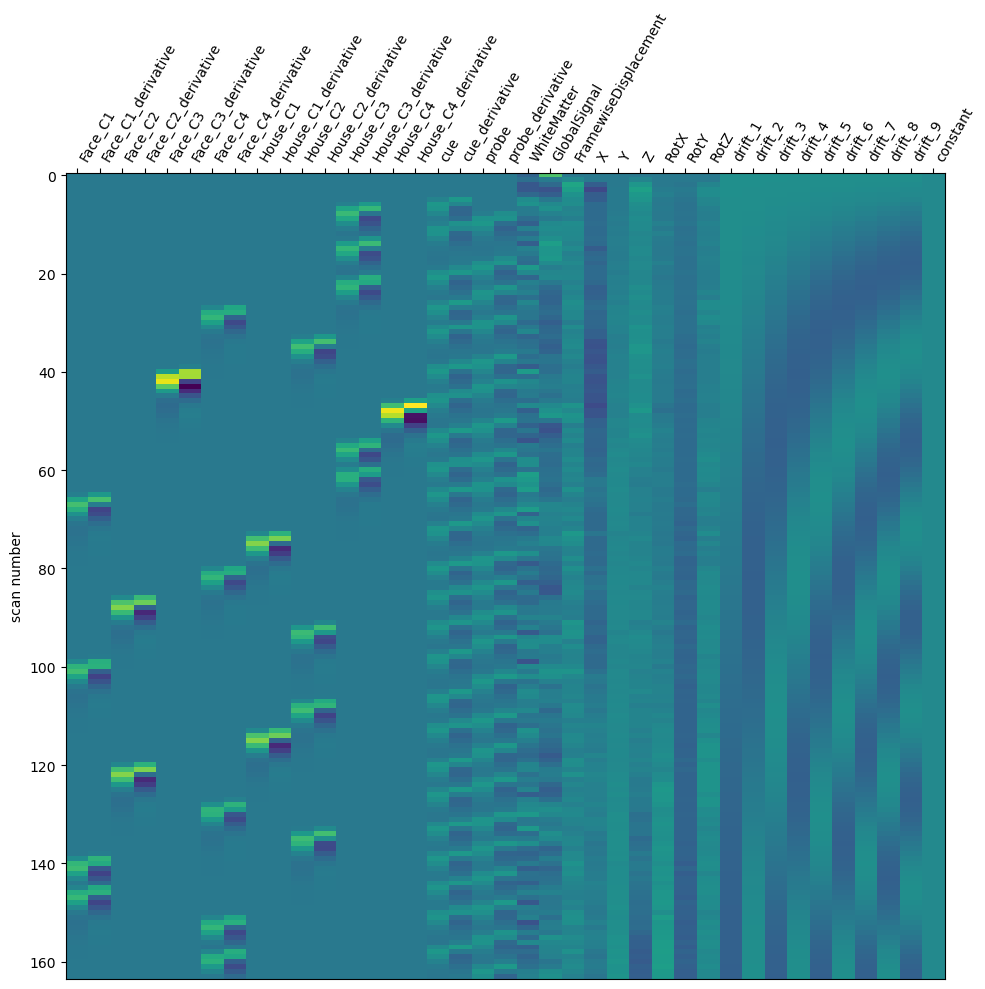

In [28]:
# Obtain and plot design matrix
design_matrix_vs2 = fmri_glm_vs2.design_matrices_[0]
plot_design_matrix(design_matrix_vs2)
plt.show()

## Plotting signals for each event (only showing signals from 1st fmri run)

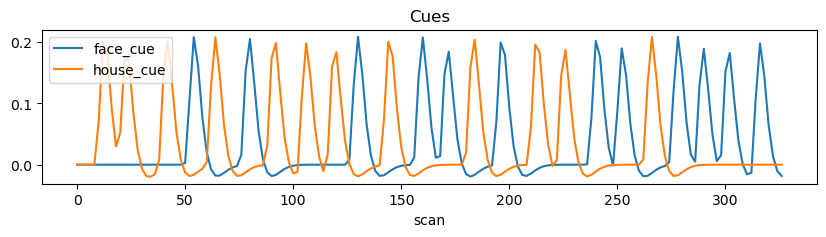

In [29]:
plt.figure(figsize=(10, 2))
plt.plot(design_matrix_cue['face_cue'], label='face_cue')
plt.plot(design_matrix_cue['house_cue'], label='house_cue')
plt.xlabel('scan')
plt.title('Cues')
plt.legend(loc='upper left')
plt.show()


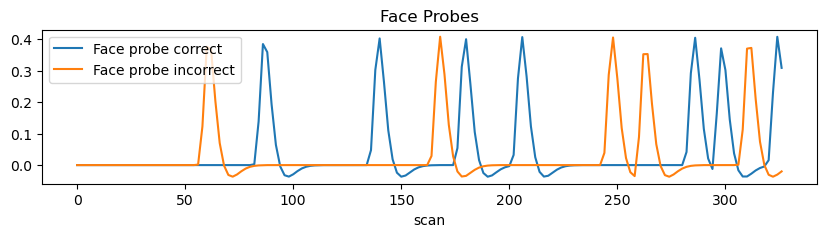

In [30]:
plt.figure(figsize=(10, 2))
plt.plot(design_matrix_probe['Face_correct'], label='Face probe correct')
plt.plot(design_matrix_probe['Face_incorrect'], label='Face probe incorrect')
plt.xlabel('scan')
plt.title('Face Probes')
plt.legend(loc='upper left')
plt.show()

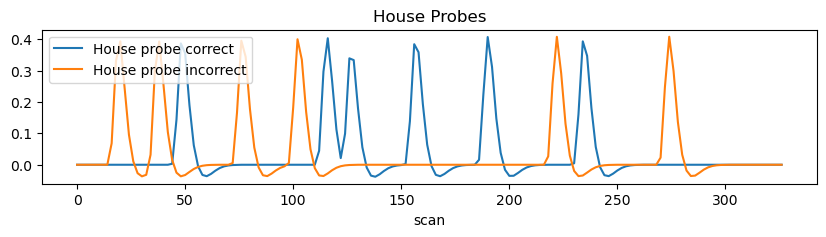

In [31]:
plt.figure(figsize=(10, 2))
plt.plot(design_matrix_probe['House_correct'], label='House probe correct')
plt.plot(design_matrix_probe['House_incorrect'], label='House probe incorrect')
plt.xlabel('scan')
plt.title('House Probes')
plt.legend(loc='upper left')
plt.show()

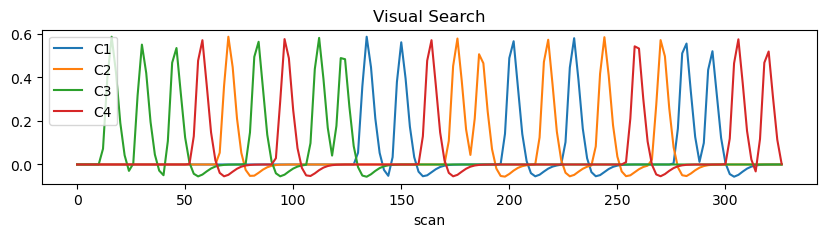

In [32]:
plt.figure(figsize=(10, 2))
plt.plot(design_matrix_vs['C1'], label='C1')
plt.plot(design_matrix_vs['C2'], label='C2')
plt.plot(design_matrix_vs['C3'], label='C3')
plt.plot(design_matrix_vs['C4'], label='C4')
plt.xlabel('scan')
plt.title('Visual Search')
plt.legend(loc='upper left')
plt.show()

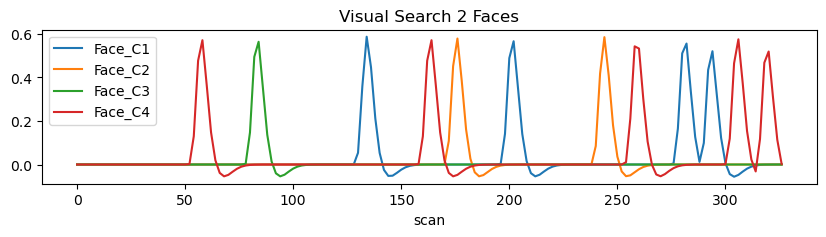

In [33]:
plt.figure(figsize=(10, 2))
plt.plot(design_matrix_vs2['Face_C1'], label='Face_C1')
plt.plot(design_matrix_vs2['Face_C2'], label='Face_C2')
plt.plot(design_matrix_vs2['Face_C3'], label='Face_C3')
plt.plot(design_matrix_vs2['Face_C4'], label='Face_C4')
plt.xlabel('scan')
plt.title('Visual Search 2 Faces')
plt.legend(loc='upper left')
plt.show()

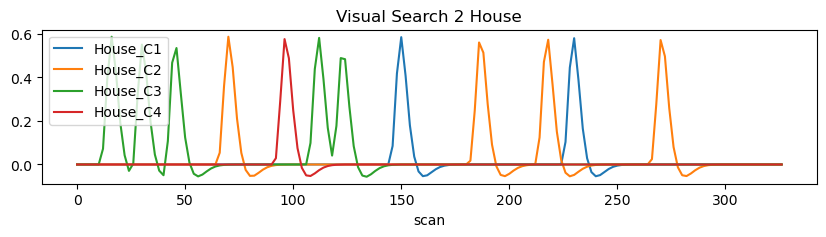

In [34]:
plt.figure(figsize=(10, 2))
plt.plot(design_matrix_vs2['House_C1'], label='House_C1')
plt.plot(design_matrix_vs2['House_C2'], label='House_C2')
plt.plot(design_matrix_vs2['House_C3'], label='House_C3')
plt.plot(design_matrix_vs2['House_C4'], label='House_C4')
plt.xlabel('scan')
plt.title('Visual Search 2 House')
plt.legend(loc='upper left')
plt.show()

## Ploting contrasts

In [35]:
def plot_contrast(contrast, title):
    
    # Get raw contrast activation
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')
    
    # Get clean contrast and threshold to visualize results
    # Threshold: false discovery rate 5% w/ cluster > 8 voxels
    clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)
    s_threshold = str(round(threshold, 1))
    
    # Plot contrast
    dim = ['x', 'y', 'z']
    for x in range(3):
    
        plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('' + title + ' (Z>' + s_threshold + '), fdr = .05')) 

### Face cue 

In [36]:
# Get raw contrast activation
z_map = fmri_glm_cue.compute_contrast('+1*face_cue -1*house_cue', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') #, cluster_threshold=5
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:658: UserWarning: One contrast given, assuming it for all 8 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


FDR(0.05) threshold: 3.4


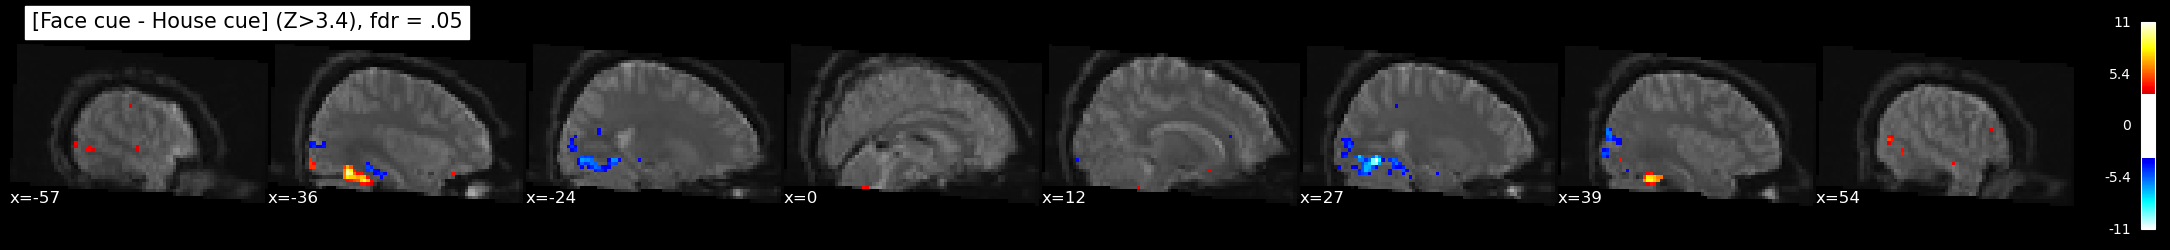

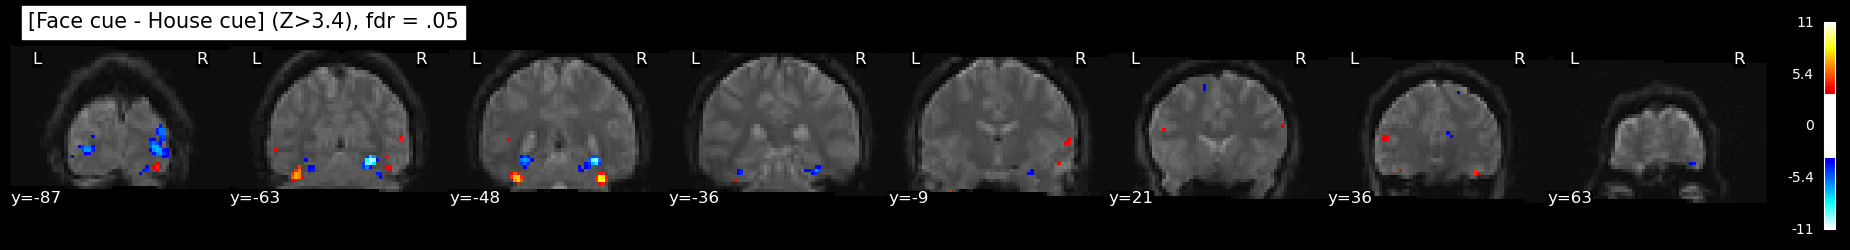

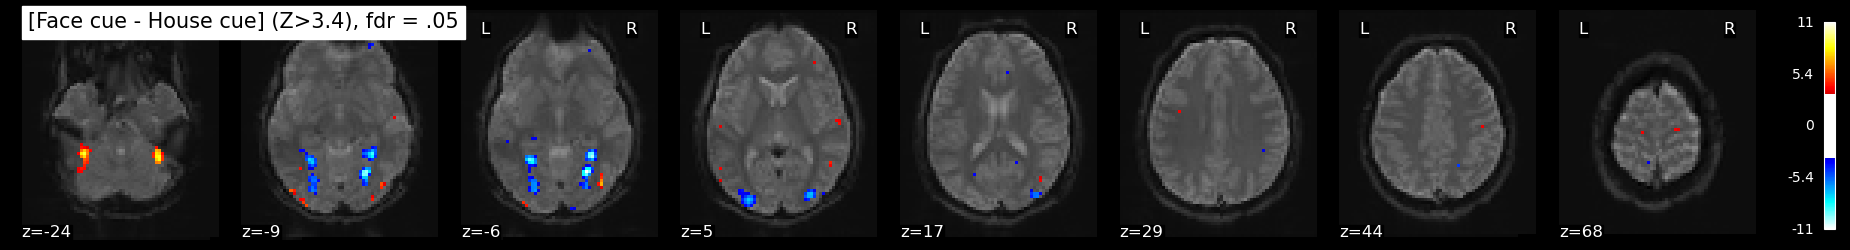

In [37]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face cue - House cue] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### House cue

In [38]:
# Get raw contrast activation
z_map = fmri_glm_cue.compute_contrast('+1*house_cue -1*face_cue', output_type='z_score')

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5%
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.4


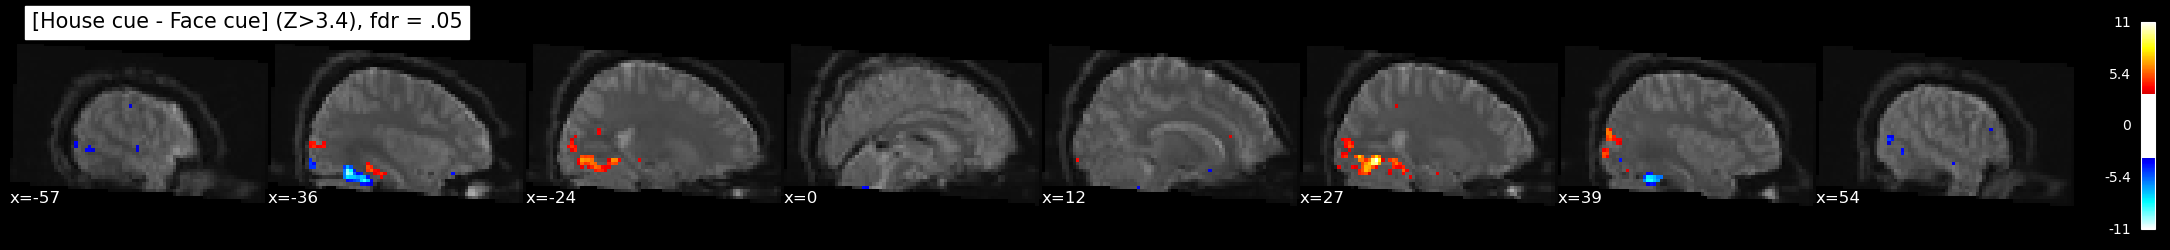

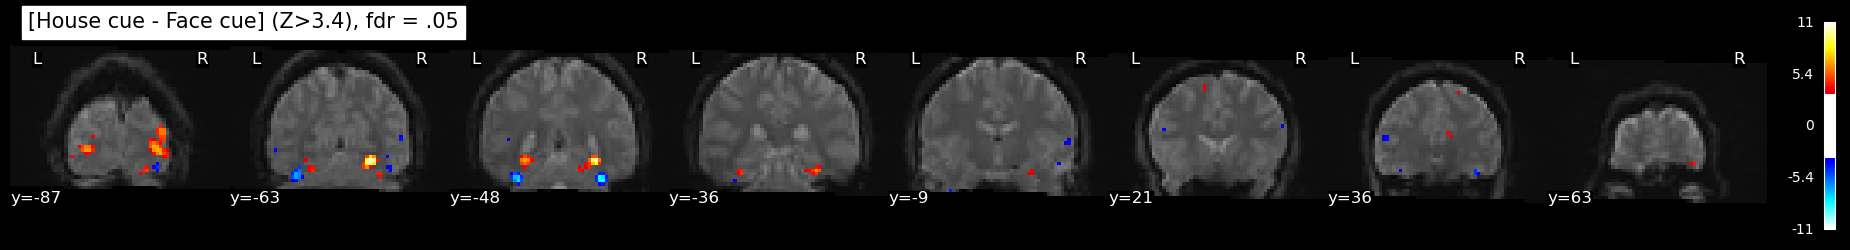

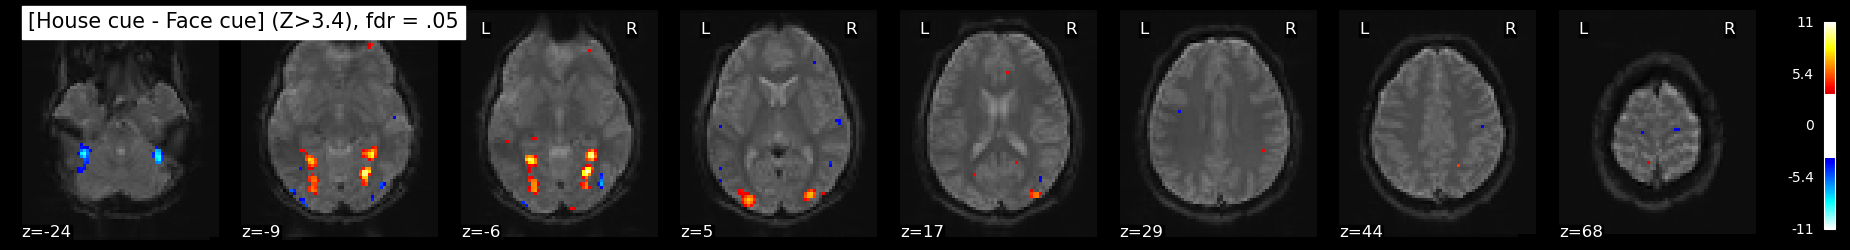

In [39]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House cue - Face cue] (Z>' + s_threshold + '), fdr = .05'))
    plt.show()

### Face probe (Face correct - Face incorrect)

In [40]:
# Get raw contrast activation
z_map = fmri_glm_probe.compute_contrast('+1*Face_correct-1*Face_incorrect', output_type='z_score') 

print(type(z_map))
# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

<class 'nibabel.nifti1.Nifti1Image'>
FDR(0.05) threshold: inf


/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


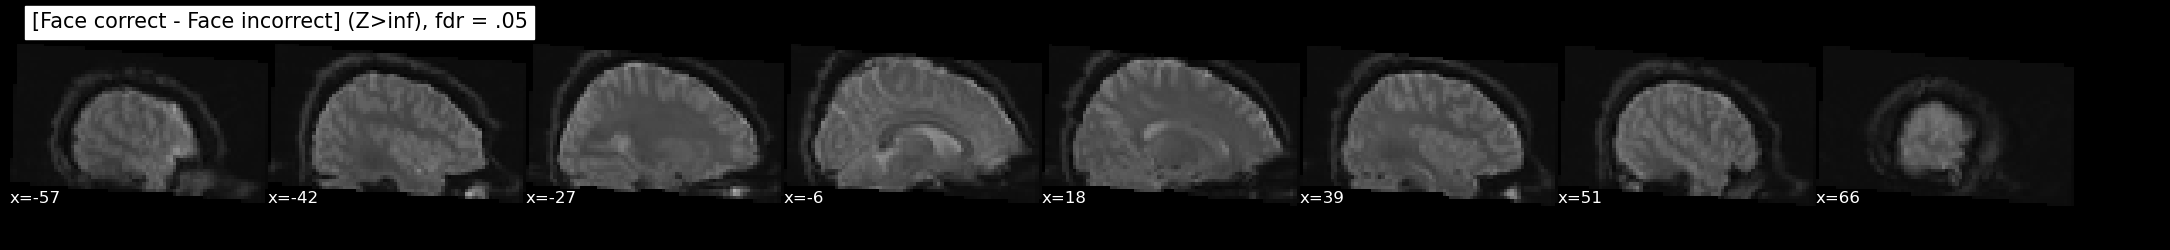

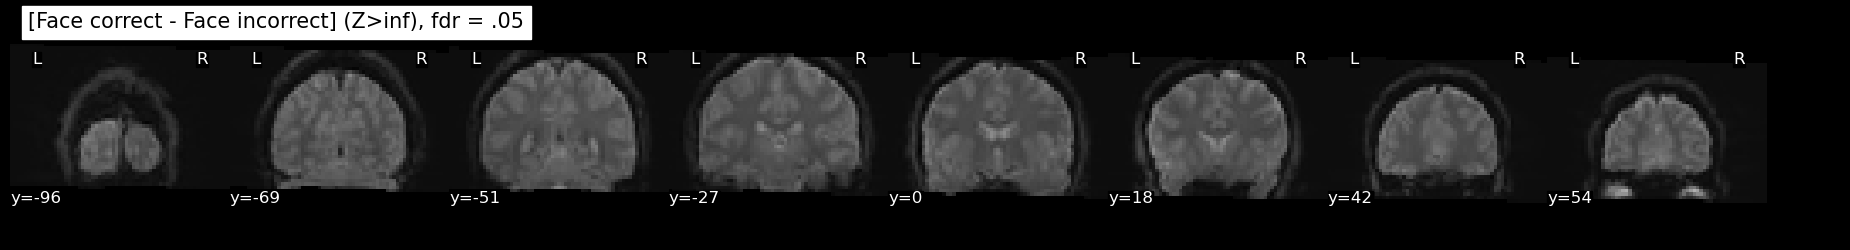

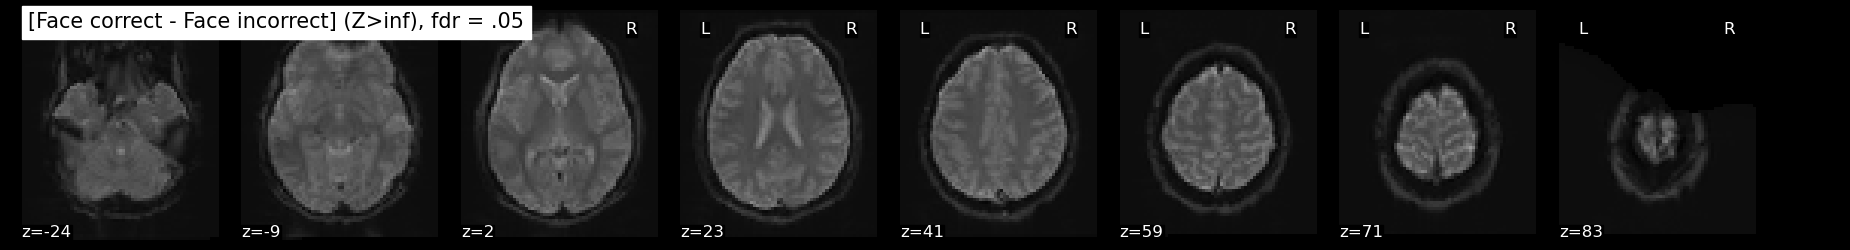

In [41]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(z_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Face correct - Face incorrect] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

##### Plotting with ~arbitrary threshold (2.6)

In [42]:
# Visualize results
#dim = ['x', 'y', 'z']

#for x in range(3):
    
#    plot_stat_map(z_map, threshold=2.6, bg_img=mean_img,
#              display_mode=dim[x], cut_coords=8, black_bg=True,
#              title=('[Face correct - Face incorrect] (Z>' + s_threshold + '), fdr = .05')) 
#    plt.show()

### House probe (House correct - House incorrect)

In [43]:
# Get raw contrast activation
z_map = fmri_glm_probe.compute_contrast('+1*House_correct-1*House_incorrect', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.5


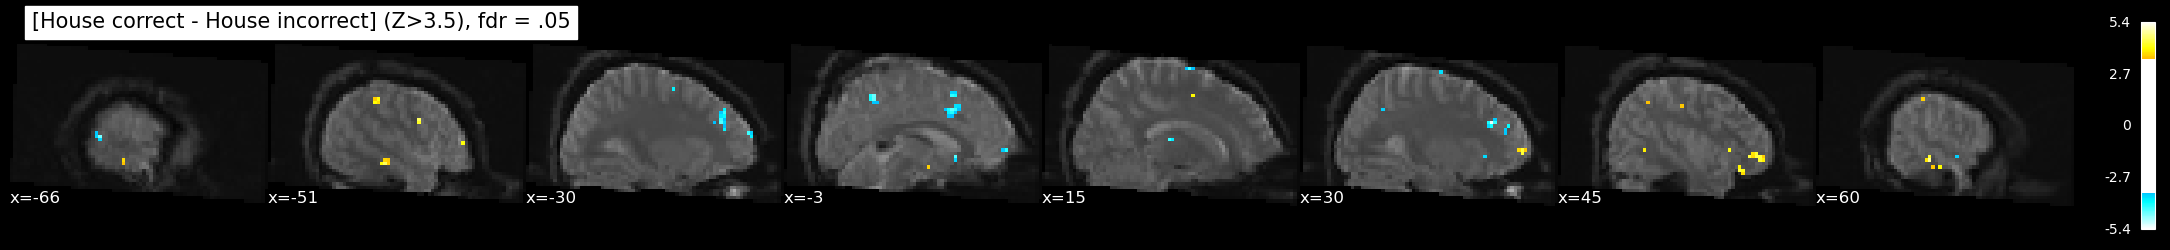

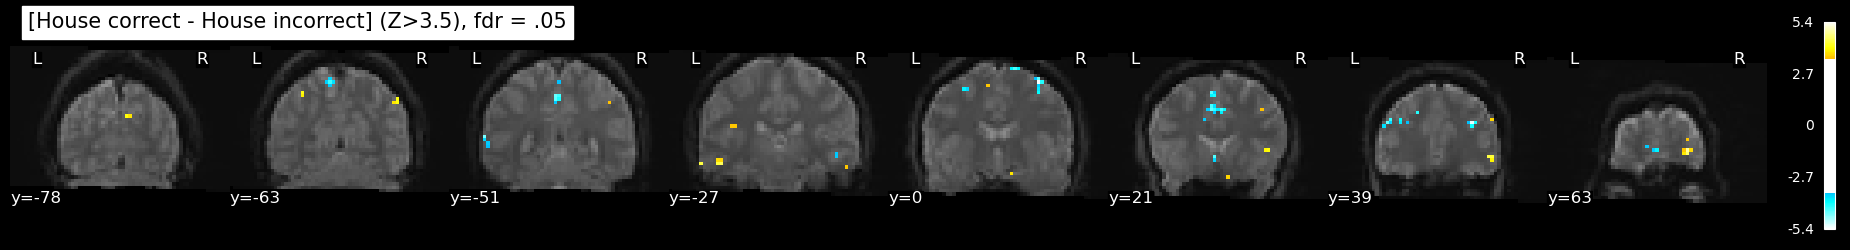

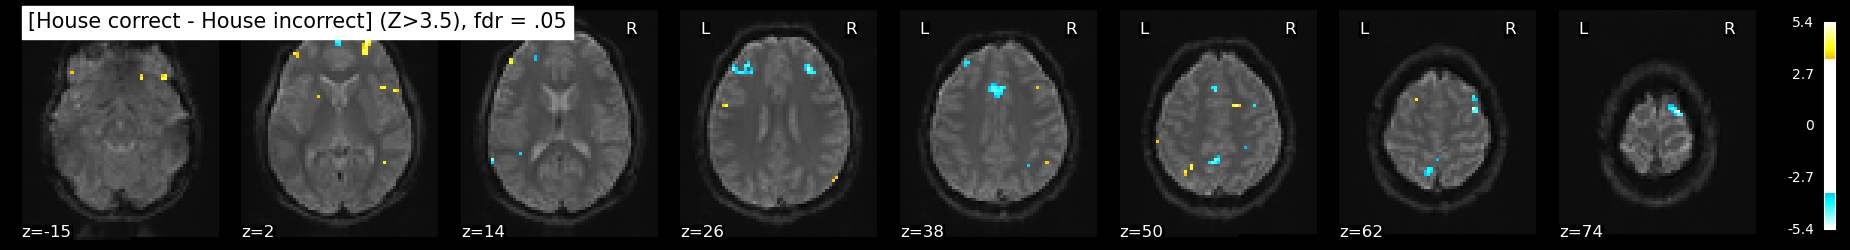

In [44]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[House correct - House incorrect] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### Probes (Correct - Incorrect)

In [45]:
# Get raw contrast activation
z_map = fmri_glm_probe.compute_contrast('+1*Face_correct+1*House_correct-1*House_incorrect-1*Face_incorrect', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: inf


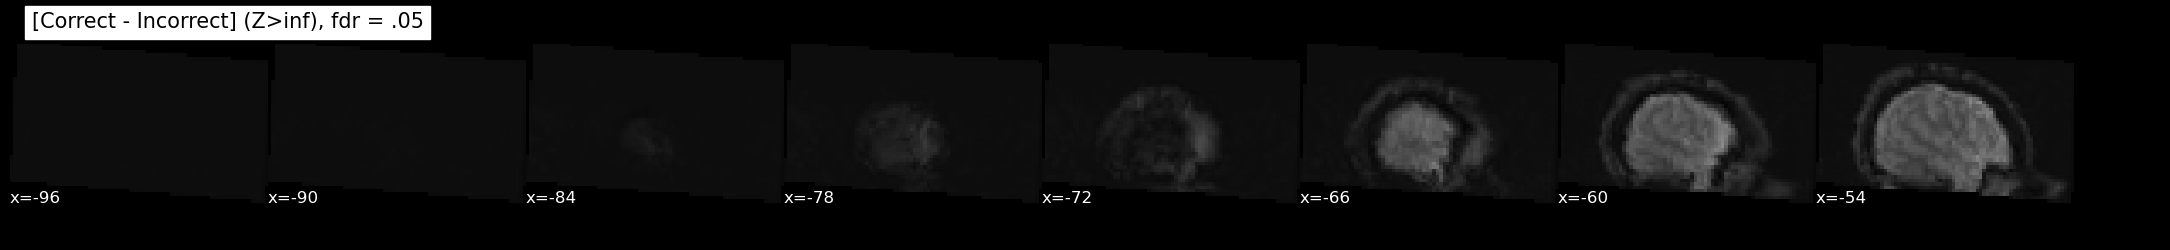

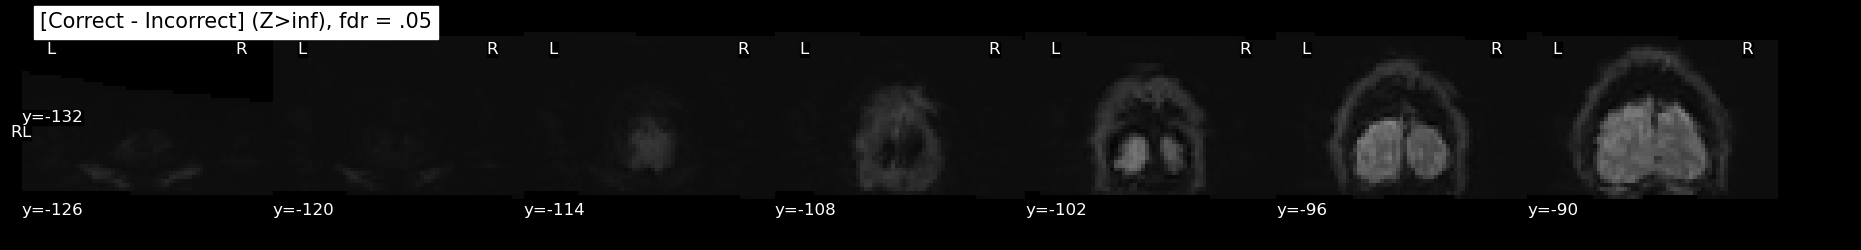

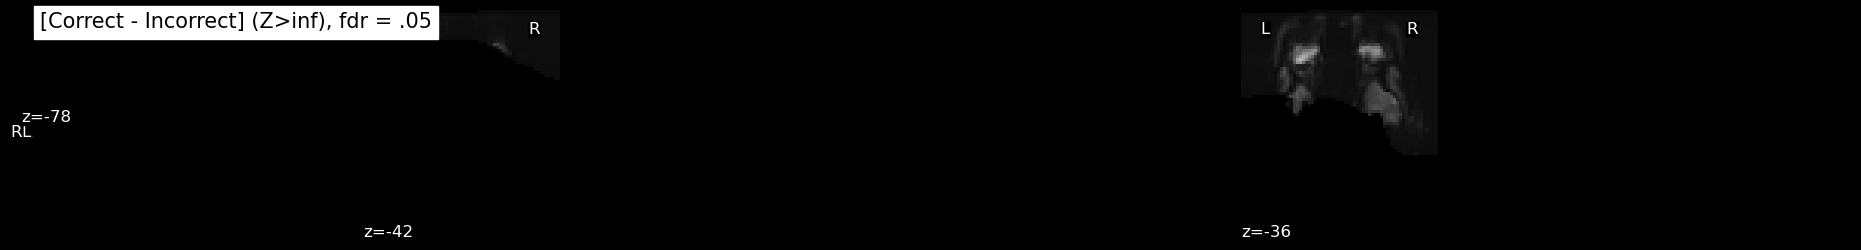

In [46]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Correct - Incorrect] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

### Probes (Face - House)

In [47]:
# Get raw contrast activation
z_map = fmri_glm_probe.compute_contrast('+1*Face_correct+1*Face_incorrect-1*House_correct-1*House_incorrect', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 3.9


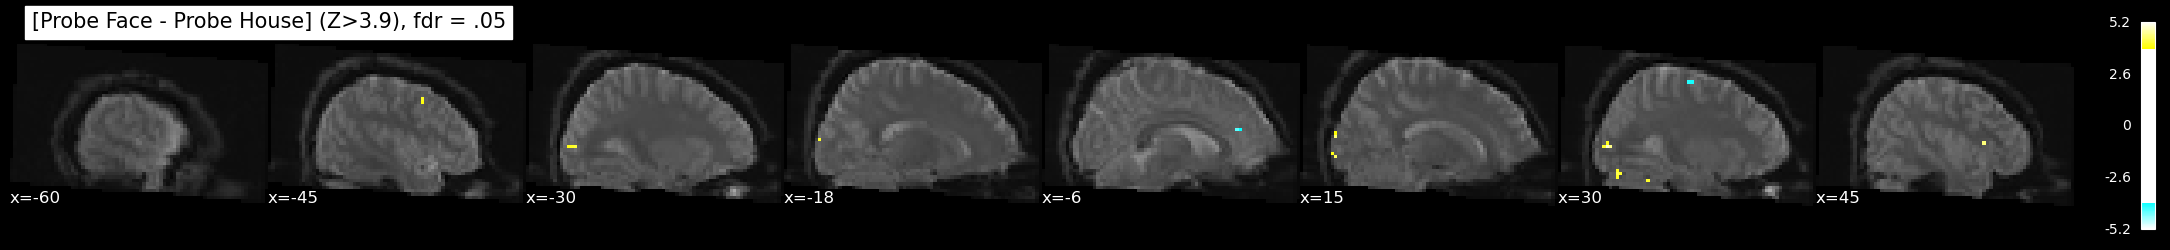

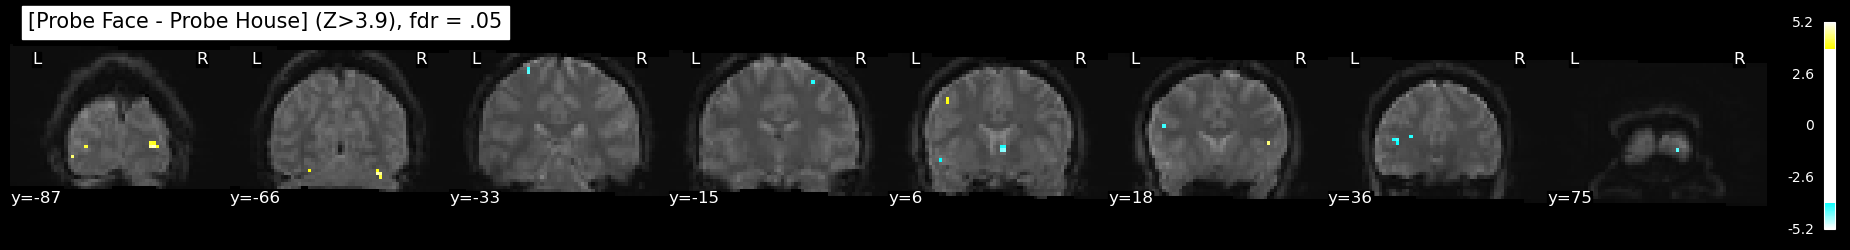

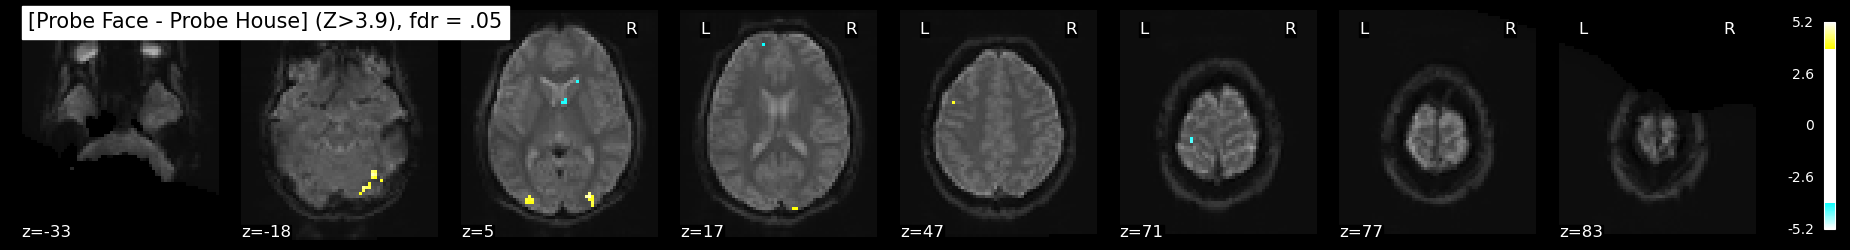

In [48]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[Probe Face - Probe House] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

##### Plotting with ~arbitrary threshold (2.5)

In [49]:
# Visualize results
#dim = ['x', 'y', 'z']

#for x in range(3):
    
#    plot_stat_map(z_map, threshold=2.5, bg_img=mean_img,
#              display_mode=dim[x], cut_coords=8, black_bg=True,
#              title=('[Probe Face - Probe House] (Z>' + s_threshold + '), fdr = .05')) 
#    plt.show()

### Visual Search (High interference - Low interference)

In [50]:
# Get raw contrast activation
z_map = fmri_glm_vs.compute_contrast('+1*C4+1*C3 -1*C2-1*C1', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') #0.6 -> to get significant voxels
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 4.2


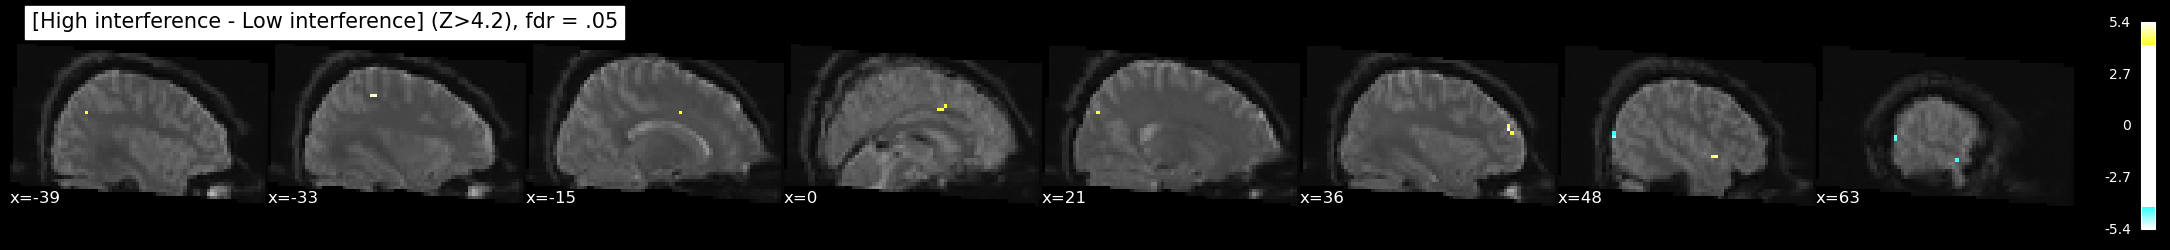

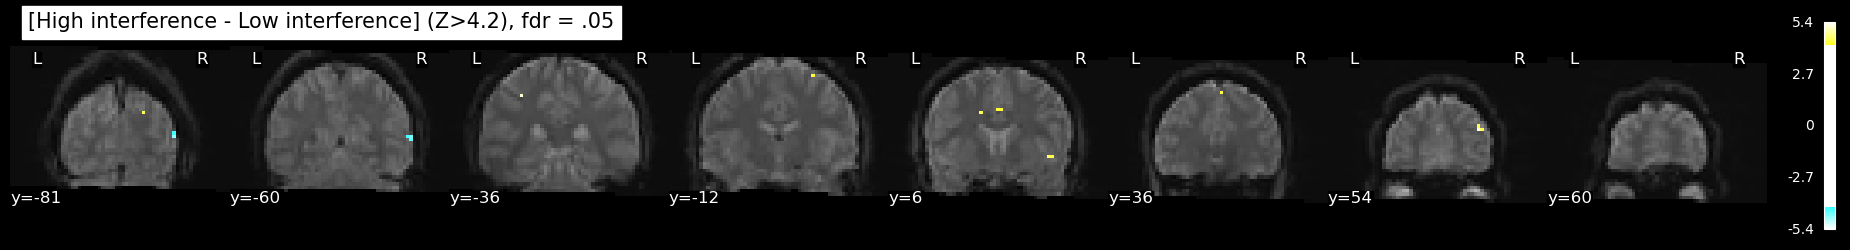

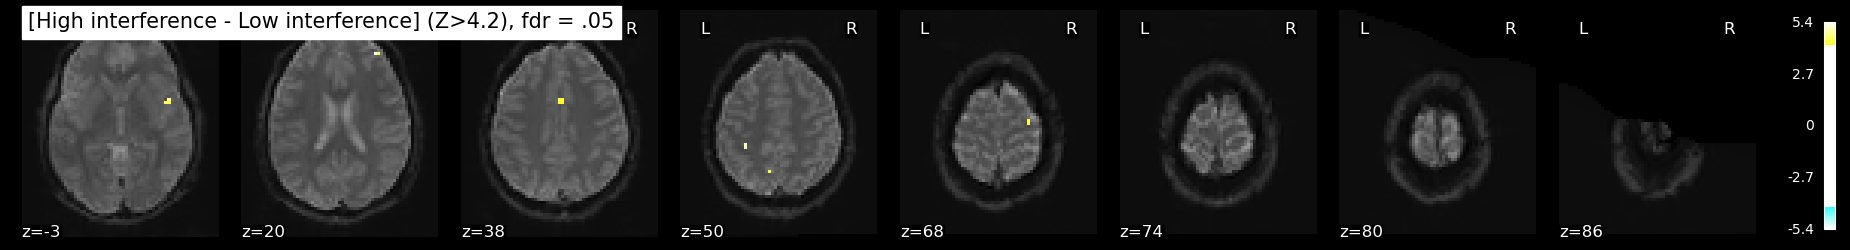

In [51]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[High interference - Low interference] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

##### Plotting with ~arbitrary threshold (2.5)

In [52]:
# Visualize results
#dim = ['x', 'y', 'z']

#for x in range(3):
    
#    plot_stat_map(z_map, threshold=2.5, bg_img=mean_img,
#              display_mode=dim[x], cut_coords=8, black_bg=True,
#              title=('[High interference - Low interference] (Z>' + s_threshold + '), fdr = .05')) 
#    plt.show()

### Visual Search (Attentional demand high - low)

In [53]:
# Get raw contrast activation
z_map = fmri_glm_vs.compute_contrast('+1*C4+1*C2 -1*C3-1*C1', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') 
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 4.2


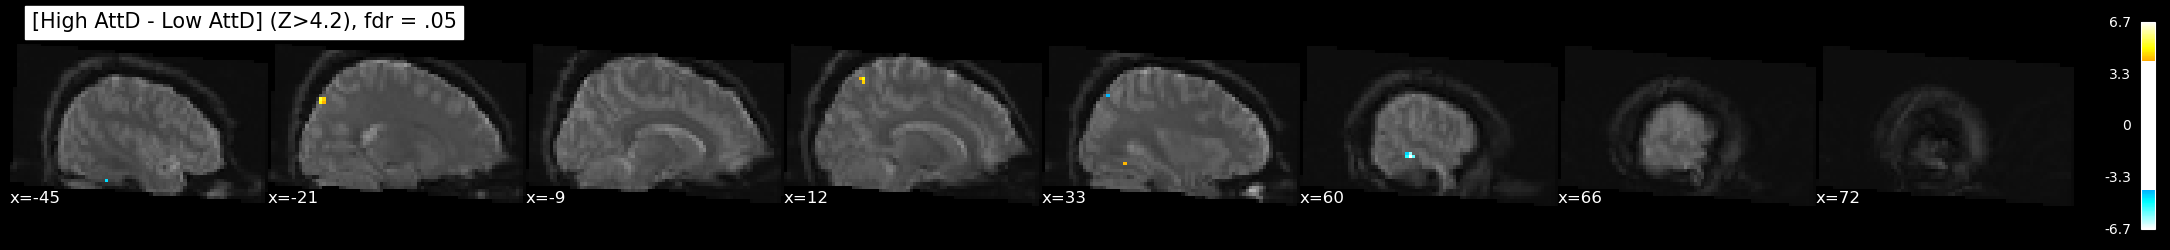

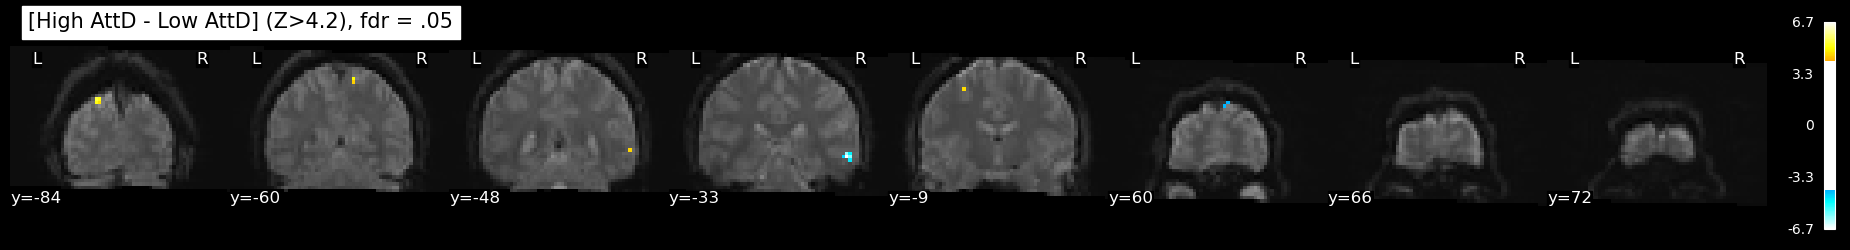

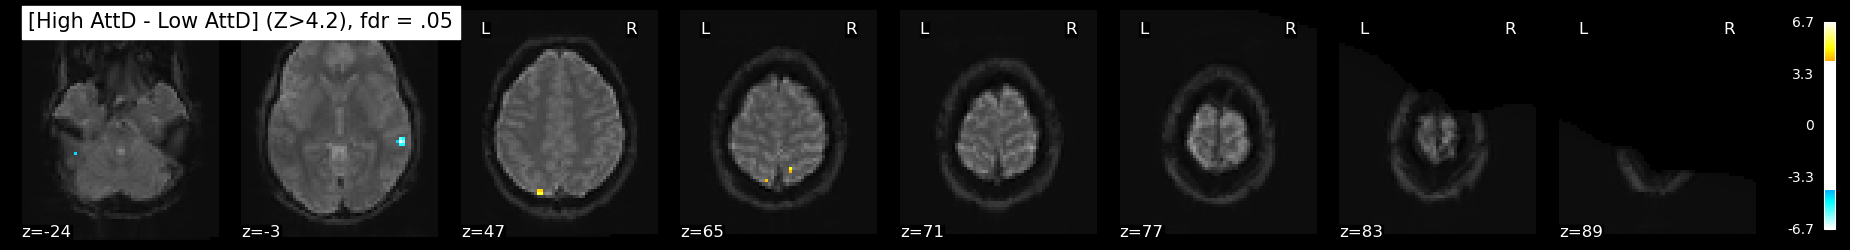

In [54]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[High AttD - Low AttD] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

##### Plotting with ~arbitrary threshold (2.5)

In [55]:
# Visualize results
#dim = ['x', 'y', 'z']

#for x in range(3):
    
#    plot_stat_map(z_map, threshold=2.5, bg_img=mean_img,
#              display_mode=dim[x], cut_coords=8, black_bg=True,
#              title=('[High AttD - Low AttD] (Z>' + s_threshold + '), fdr = .05')) 
#    plt.show()

### Visual Search2 (High interference - Low interference)

In [56]:
# Get raw contrast activation
z_map = fmri_glm_vs2.compute_contrast('+1*Face_C4+1*House_C4+1*Face_C3+1*House_C3 -1*Face_C2-1*House_C2-1*Face_C1-1*House_C1', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr') #.2 -> to get significant voxels
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

/Users/RaulAlvarez/opt/anaconda3/envs/py36/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:658: UserWarning: One contrast given, assuming it for all 7 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


FDR(0.05) threshold: 3.6


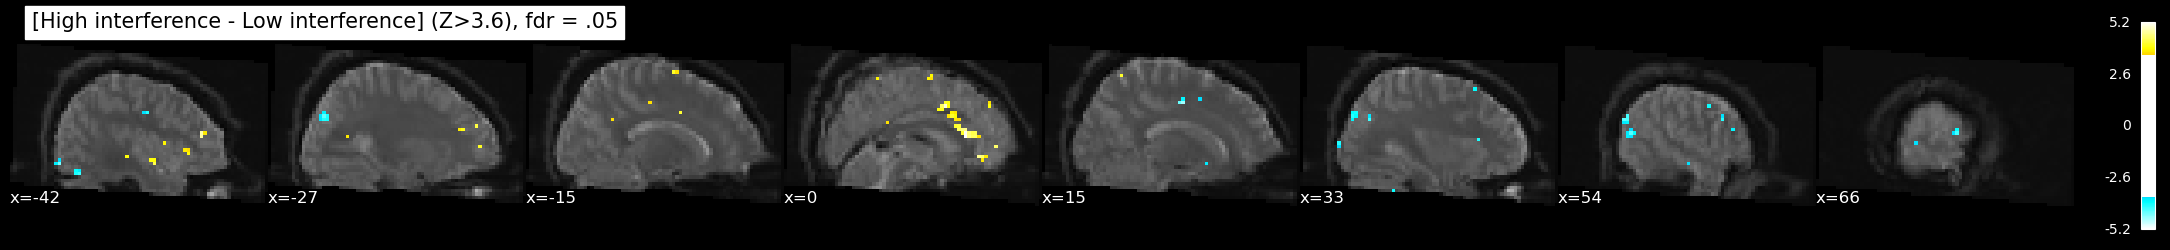

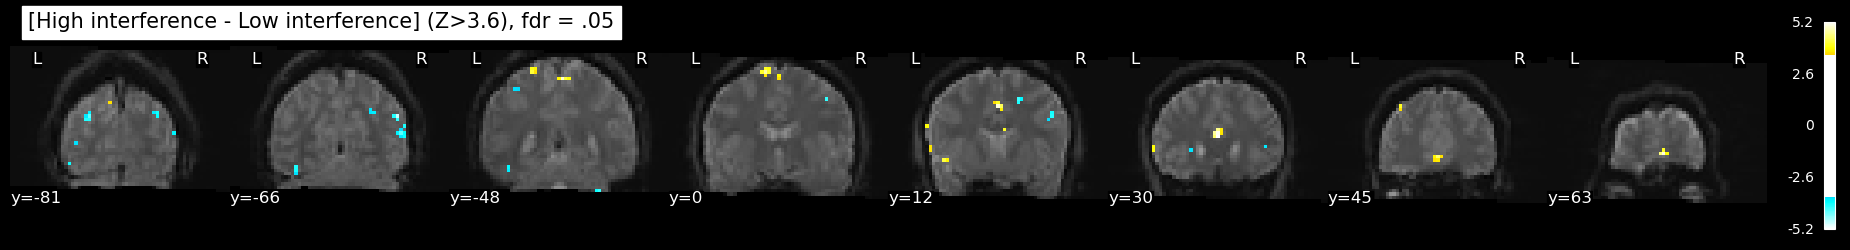

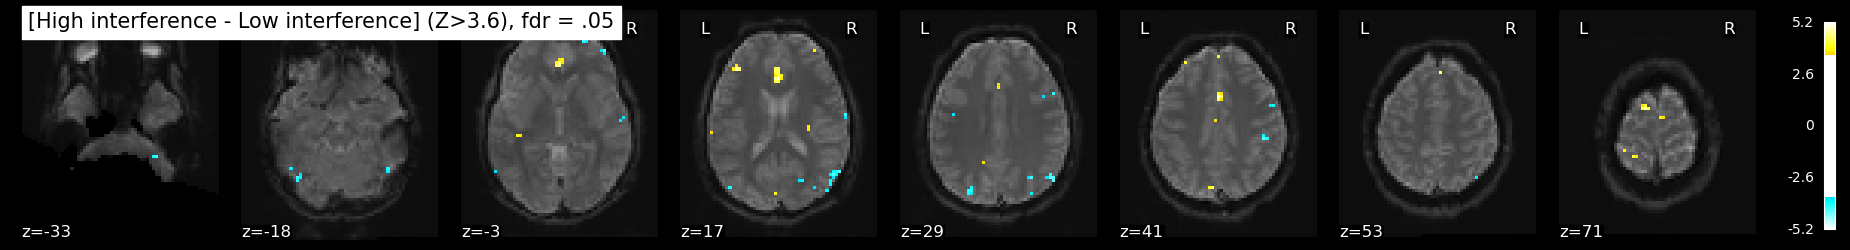

In [57]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[High interference - Low interference] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

##### Plotting with ~arbitrary threshold (2.5)

In [58]:
# Visualize results
#dim = ['x', 'y', 'z']

#for x in range(3):
    
    #plot_stat_map(z_map, threshold=2.5, bg_img=mean_img,
    #          display_mode=dim[x], cut_coords=8, black_bg=True,
    #          title=('[High interference - Low interference] (Z>' + s_threshold + '), fdr = .05')) 
    #plt.show()

### Visual Search2 (Attentional demand high - low)

In [59]:
# Get raw contrast activation
z_map = fmri_glm_vs2.compute_contrast('+1*Face_C4+1*House_C4+1*Face_C2+1*House_C2 -1*Face_C3-1*House_C3-1*Face_C1-1*House_C1', output_type='z_score') 

# Get clean contrast and threshold to visualize results
# Threshold: false discovery rate 5% 
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
s_threshold = str(round(threshold, 1))
print("FDR(0.05) threshold: " + s_threshold)

FDR(0.05) threshold: 4.4


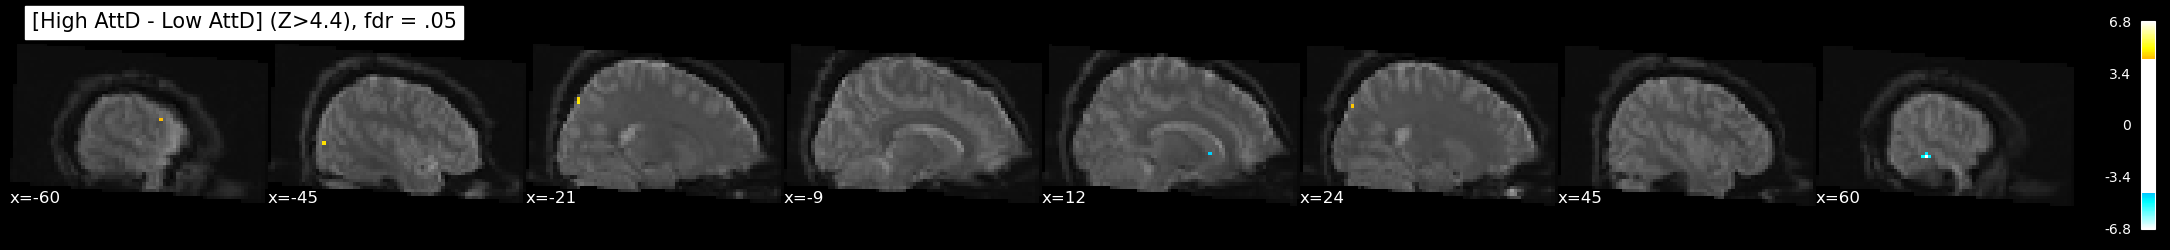

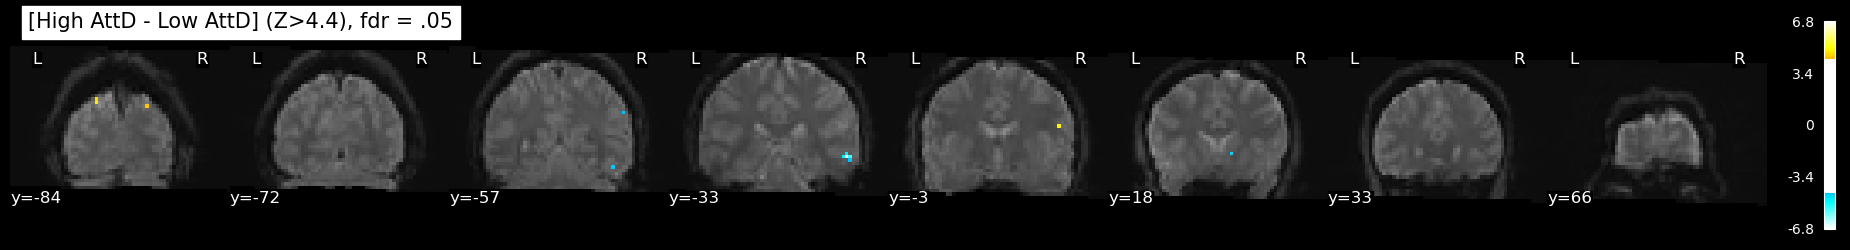

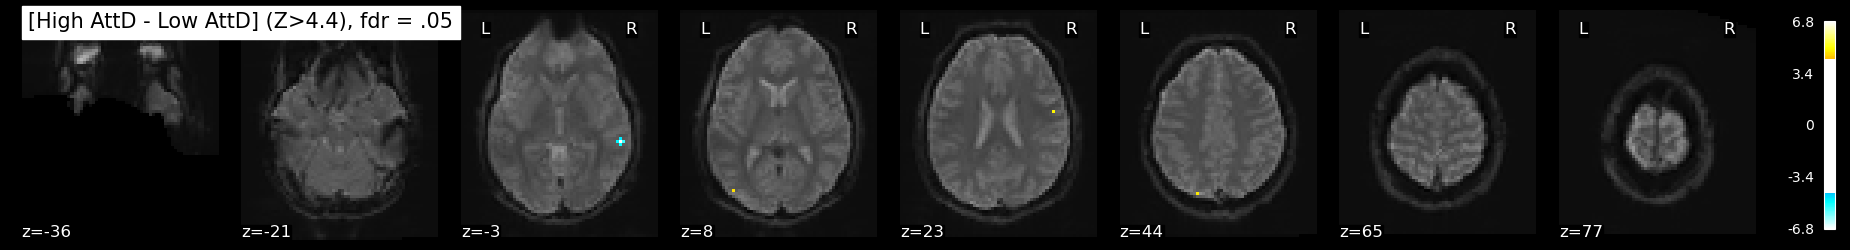

In [60]:
# Visualize results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(z_map, threshold=threshold, bg_img=mean_img,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title=('[High AttD - Low AttD] (Z>' + s_threshold + '), fdr = .05')) 
    plt.show()

In [61]:
"""
def extracting_events_info_4vs(data_df):
    
    events_vs = pd.DataFrame()
    
    #num_of_trials = df["block"].size
    # Process data for 'events df'
    for x in range(24):

        # Formating data for 'cue', 'probe' and 'visual search' events
        cue_onset = data_df["cueShow"][x] 
        probe_onset = data_df["probeStart"][x] 
        vs_onset = data_df["searchStart"][x]

        probe_duration = data_df["ProbeDuration"][x]
        vs_duration = data_df["SearchDuration"][x]
        cue_duration = data_df["CueDuration"][x]

        # Useful vars to sort vs category
        probe = data_df["targstim"][x]
        probe_interference = data_df["SearchDomain"][x]
        probe_att_d = data_df["SearchLevel"][x]
    
        # Categorize each run according to 'type of stimuli', 'level of interference' and 'attentional demand'
        if((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "house_cue"
            probe_type = "probe" 
            visual_search_type = "face_c1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "easy")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "house_c1"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "house_cue"
            probe_type = "probe"
            visual_search_type = "face_c2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "diff") and (probe_att_d == "hard")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "house_c2"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "house_cue"
            probe_type = "probe" 
            visual_search_type = "house_c3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "easy")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "face_c3"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] == "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "house_cue"
            probe_type = "probe" 
            visual_search_type = "house_c4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)
        elif((probe[:5] != "House") and (probe_interference == "same") and (probe_att_d == "hard")):
            cue_type = "face_cue"
            probe_type = "probe" 
            visual_search_type = "face_c4"
            vs_event = pd.DataFrame(data={'trial_type': visual_search_type, 'onset': vs_onset, 'duration': vs_duration}, index=range(1))
            events_vs = events_vs.append(vs_event, ignore_index = True)

        cue_event = pd.DataFrame(data={'trial_type': cue_type, 'onset': cue_onset, 'duration': cue_duration}, index=range(1))
        probe_event = pd.DataFrame(data={'trial_type': probe_type, 'onset': probe_onset, 'duration': probe_duration}, index=range(1))
    
        # Appending data to events df
        events_vs = events_vs.append(cue_event, ignore_index = True)
        events_vs = events_vs.append(probe_event, ignore_index = True)
        
    return events_vs
"""

'\ndef extracting_events_info_4vs(data_df):\n    \n    events_vs = pd.DataFrame()\n    \n    #num_of_trials = df["block"].size\n    # Process data for \'events df\'\n    for x in range(24):\n\n        # Formating data for \'cue\', \'probe\' and \'visual search\' events\n        cue_onset = data_df["cueShow"][x] \n        probe_onset = data_df["probeStart"][x] \n        vs_onset = data_df["searchStart"][x]\n\n        probe_duration = data_df["ProbeDuration"][x]\n        vs_duration = data_df["SearchDuration"][x]\n        cue_duration = data_df["CueDuration"][x]\n\n        # Useful vars to sort vs category\n        probe = data_df["targstim"][x]\n        probe_interference = data_df["SearchDomain"][x]\n        probe_att_d = data_df["SearchLevel"][x]\n    \n        # Categorize each run according to \'type of stimuli\', \'level of interference\' and \'attentional demand\'\n        if((probe[:5] == "House") and (probe_interference == "diff") and (probe_att_d == "easy")):\n            cue_t

In [62]:
"""
for x in range(8):
    run = "Run " + str(x + 1) + ": "
    title = run + "Visual Search"
    plt.figure(figsize=(12, 1.5))
    plt.plot(fmri_glm_vs.design_matrices_[x]['C1'], label='C1')
    plt.plot(fmri_glm_vs.design_matrices_[x]['C2'], label='C2')
    plt.plot(fmri_glm_vs.design_matrices_[x]['C3'], label='C3')
    plt.plot(fmri_glm_vs.design_matrices_[x]['C4'], label='C4')
    plt.xlabel('scan')
    plt.suptitle(title)
    #plt.title('Visual Search')
    plt.legend(loc='upper left')
    plt.show()
"""

'\nfor x in range(8):\n    run = "Run " + str(x + 1) + ": "\n    title = run + "Visual Search"\n    plt.figure(figsize=(12, 1.5))\n    plt.plot(fmri_glm_vs.design_matrices_[x][\'C1\'], label=\'C1\')\n    plt.plot(fmri_glm_vs.design_matrices_[x][\'C2\'], label=\'C2\')\n    plt.plot(fmri_glm_vs.design_matrices_[x][\'C3\'], label=\'C3\')\n    plt.plot(fmri_glm_vs.design_matrices_[x][\'C4\'], label=\'C4\')\n    plt.xlabel(\'scan\')\n    plt.suptitle(title)\n    #plt.title(\'Visual Search\')\n    plt.legend(loc=\'upper left\')\n    plt.show()\n'